##A W-Net Based Architecture with Residual Block for Liver Segmentation

https://www.kaggle.com/datasets/maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')  #掛載Google雲端硬碟

Mounted at /content/gdrive/


In [ ]:
os.chdir('/content/gdrive/My Drive/COVID') #切換該目錄 根據妳雲端硬碟的資料夾名稱
os.listdir() #確認該目錄下之內容

['image', 'mask']

In [ ]:
import numpy as np # 數值計算和陣列操作
import os #作業系統互動
from PIL import Image #用於圖像的開啟、操作和儲存
import matplotlib.pyplot as plt #用於繪製和顯示圖像、資料和圖表
import cv2 #用於圖像和影片處理、電腦視覺任務等

In [ ]:
data_file = '/content/gdrive/My Drive/COVID/'  #路徑設定
image_file = data_file+'image/'
mask_file = data_file+'mask/'

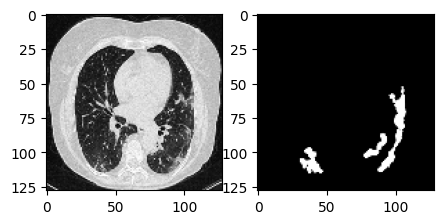

In [ ]:
data_name = "bjorke_95.png"  #確認img 與 mask是否相符
img_path = os.path.join(image_file+data_name) #組合圖像檔案的完整路徑
img = cv2.imread(img_path) #使用OpenCV讀取圖像檔案
img = cv2.resize(img, (128, 128)) #將圖像調整為大小為128x128
mask_path = os.path.join(mask_file+data_name) #組合mask檔案的完整路徑，其中mask檔案的命名規則是根據圖像檔案的前三個字元加上".png"
mask = cv2.imread(mask_path) #使用OpenCV讀取mask檔案
mask = cv2.resize(mask, (128, 128)) #將mask圖像調整為大小為128x128
plt.figure(figsize=(5, 8)) #建立一個大小為5x8的畫布，用於顯示圖像和mask
plt.subplot(1, 2, 1) #設定畫布上的子圖位置，1行2列中的第1個位置
plt.imshow(cv2.cvtColor (img, cv2.COLOR_BGR2RGB)) #顯示轉換為RGB顏色空間的圖像
plt.subplot(1, 2, 2) #設定畫布上的子圖位置，1行2列中的第2個位置
plt. imshow (mask) #顯示mask圖像

##讀入資料

In [ ]:
Image = []  #創建空的列表用於存儲圖像、mask
Mask = []
for data_name in os.listdir(image_file): #遍歷指定目錄中的檔案
  if data_name[-4:]=='.png':  #檢查檔案的副檔名是否為".png"
    img_path = os.path.join(image_file+data_name) #組合圖像檔案的完整路徑
    img = cv2.imread(img_path) #使用OpenCV讀取圖像檔案
    img = cv2.resize(img, (128,128)) #將圖像調整為大小為128x128
    mask_path = os.path.join(mask_file+data_name) #組合mask檔案的完整路徑
    mask = cv2.imread(mask_path) #使用OpenCV讀取mask檔案
    mask = cv2.resize(mask, (128,128))  #將mask圖像調整為大小為128x128
    Image.append(img) #將處理後的圖像和mask添加到相應的列表中
    Mask.append(mask)

Image = np.array(Image) #將圖像、mask列表轉換為NumPy陣列
Mask = np.array(Mask)

Image.shape, Mask.shape #顯示圖像、mask、陣列的形狀（尺寸）

((100, 128, 128, 3), (100, 128, 128, 3))

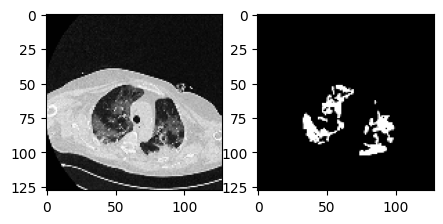

In [ ]:
i = 0  #再次檢查有無對應正確mask
plt.figure(figsize=(5, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(Image[i], cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(Mask[i])

#影像正規化與標籤處理

In [ ]:
Image_norm = Image / 255 #將圖像數值除以255，以實現圖像數值的正規化，將其範圍縮放到0到1之間
Mask_norm = Mask / 255 #將遮罩數值除以255，以實現遮罩數值的正規化，將其範圍縮放到0到1之間

##拆分訓練集、驗證集和測試集

In [ ]:
from sklearn.model_selection import train_test_split
#image與mask
X_train_val, X_test, Y_train_val_mask, Y_test_mask = train_test_split(Image_norm,Mask_norm,test_size=0.2, random_state=8) #將圖像數據集（Image_norm）和遮罩數據集（Mask_norm）按照指定的比例（test_size=0.1）進行隨機拆分，得到訓練驗證集和測試集的圖像和mask數據。這裡的拆分比例是將10%的數據劃分為測試集，而剩餘的90%作為訓練驗證集
X_train, X_val, Y_train_mask, Y_val_mask = train_test_split(X_train_val,Y_train_val_mask,test_size=0.2, random_state=8)  #將訓練驗證集（X_train_val, Y_train_val_mask）按照指定的比例（test_size=0.1）進行隨機拆分，得到訓練集和驗證集的圖像和mask數據。這裡的拆分比例是將10%的數據劃分為驗證集，而剩餘的90%作為訓練集
X_train.shape, Y_train_mask.shape, X_val.shape, Y_val_mask.shape, X_test.shape, Y_test_mask.shape #顯示各個數據集（訓練集、驗證集、測試集）的資料


((64, 128, 128, 3),
 (64, 128, 128, 3),
 (16, 128, 128, 3),
 (16, 128, 128, 3),
 (20, 128, 128, 3),
 (20, 128, 128, 3))

#建立模型

In [ ]:
from tensorflow import keras #引入TensorFlow庫的keras模塊，用於構建深度學習模型
import tensorflow as tf #引入TensorFlow庫，用於執行深度學習相關操作
from keras import Model  #從Keras庫中引入Model類，用於定義模型結構
from tensorflow. keras import backend as K  #從Keras庫中引入backend模塊，用於設置底層後端引擎
from tensorflow. keras. layers import Input, Conv2D, Conv2DTranspose, Dropout, Concatenate, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Add  #從Keras庫中引入不同的層類型

#注意力機制
計算全局特徵和局部特徵之間的關聯性，產生一個加權的局部特徵輸出。這可以用於提升模型對於重要特徵的關注，並提升模型在特定任務上的性能

In [ ]:
def attention(g, s, num_filters):
#定義了一個名為"attention"的函式，它接受三個輸入參數：g，s和num_filters
#g：表示全局特徵（global feature）的輸入
#s：表示局部特徵（local feature）的輸入
#num_filters：指定的卷積濾波器數量
  att_g = Conv2D(num_filters, 1, padding="same")(g) #對全局特徵g進行1x1卷積操作，用以調整通道數量
  att_g = BatchNormalization()(att_g)  #對卷積結果進行批量正規化操作，用以標準化特徵數值

  att_s = Conv2D(num_filters, 1, padding = "same")(s) #)：對局部特徵s進行1x1卷積操作，用以調整通道數量
  att_s = BatchNormalization()(att_s) #對卷積結果進行批量正規化操作，用以標準化特徵數值

  out = Activation("relu")(att_g + att_s) #將經過正規化的全局特徵和局部特徵相加，並應用ReLU激活函式
  out = Conv2D(num_filters, 1, padding="same")(out) #對相加後的特徵進行1x1卷積操作，用以調整通道數量
  out = Activation("sigmoid")(out)  #將卷積結果應用sigmoid激活函式，得到一個介於0和1之間的值

  return out * s #將sigmoid輸出值乘以局部特徵s，產生加權後的局部特徵


#Residual Block

In [ ]:
def residual(inputs, filters, kernel_size=3):
#定義了一個名為"residual"的函式，它接受三個輸入參數：inputs，filters和kernel_size
#表示輸入張量（tensor）
#指定的卷積濾波器數量
#指定的卷積核大小，預設為3
  x = Conv2D(filters, kernel_size, padding='same')(inputs) #對輸入張量進行卷積操作，使用指定數量的卷積濾波器和指定的卷積核大小
  x = BatchNormalization()(x) #對卷積結果進行批量正規化操作，用以標準化特徵數值
  x = Activation('relu')(x) #對正規化後的特徵進行ReLU激活函式操作
  x = Conv2D(filters, kernel_size, padding ='same')(x) #再次對前一步操作的特徵進行卷積操作，使用相同的卷積濾波器數量和卷積核大小
  x = BatchNormalization()(x) #對卷積結果進行批量正規化操作，用以標準化特徵數值
  x = Activation('relu')(x) #對正規化後的特徵進行ReLU激活函式操作
  x = Add()([x, inputs]) #將輸入張量和最後一層的特徵相加，實現殘差連結

  return x #返回計算後的特徵張量

# #W net 模型

In [ ]:
from keras.api._v2.keras import activations
def build_model():
  inputs = Input((X_train.shape[1], X_train.shape[2],X_train.shape[3],),name = 'input')
#下採樣

  conv1 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(inputs)
  conv1 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(conv1)
  resi1 = residual(conv1, 64)
  pool1 = MaxPooling2D((2,2),strides = 2,padding = 'same')(resi1)
  drop1 = Dropout(0.2)(pool1)


  conv2 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(drop1)
  conv2 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(conv2)
  resi2 = residual(conv2, 128)
  pool2 = MaxPooling2D((2,2),strides = 2,padding = 'same')(resi2)
  drop2 = Dropout(0.2)(pool2)


  conv3 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(drop2)
  conv3 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(conv3)
  resi3 = residual(conv3, 256)
  pool3 = MaxPooling2D((2,2),strides = 2,padding = 'same')(resi3)
  drop3 = Dropout(0.2)(pool3)


  conv4 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(drop3)
  conv4 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(conv4)
  resi4 = residual(conv4, 512)
  pool4 = MaxPooling2D((2,2),strides = 2,padding = 'same')(resi4)
  drop4 = Dropout(0.2)(pool4)


  convm = Conv2D(1024,(3,3),activation = 'relu',padding = 'same')(drop4)
  convm = Conv2D(1024,(3,3),activation = 'relu',padding = 'same')(convm)
# 上採樣
  tran5 = Conv2DTranspose(512,(2,2),strides =(2,2) ,padding = 'valid',activation = 'relu')(convm)
  conc5 = Concatenate()([tran5, resi4])
  conv5 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(conc5)
  conv5 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(conv5)
  resi5 = residual(conv5, 512)
  drop5 = Dropout(0.1)(resi5)

  tran6 = Conv2DTranspose(256,(2,2),strides =(2,2),padding = 'valid',activation = 'relu')(drop5)

  att1 = attention(tran6, resi3, 256)

  conc6 = Concatenate()([resi3,att1])  #不使用tran6
  conv6 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(conc6)
  conv6 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(conv6)
  resi6 = residual(conv6, 256)
  drop6 = Dropout(0.1)(resi6)

  tran7 = Conv2DTranspose(128,(2,2),strides = 2,padding = 'valid',activation = 'relu')(drop6)

  att2 = attention(tran7, resi2, 128)

  conc7 = Concatenate()([resi2,att2])
  conv7 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(conc7)
  conv7 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(conv7)
  resi7 = residual(conv7, 128)
  drop7 = Dropout(0.1)(resi7)

  tran8 = Conv2DTranspose(64,(2,2),strides = 2,padding = 'valid',activation = 'relu')(drop7)

  att3 = attention(tran8, resi1, 64)

  conc8 = Concatenate()([resi1,att3])
  conv8 = Conv2D(64,(3,3),name="Attention4",activation = 'relu',padding = 'same')(conc8)
  conv8 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(conv8)
  resi8 = residual(conv8, 64)
  drop8 = Dropout(0.1)(resi8)
#softmax層
  soft1 = Conv2D(3,(1,1), activation='softmax',padding = 'same')(drop8)
#再度下採樣

  conv9 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(soft1)
  conv9 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(conv9)
  resi9 = residual(conv9, 64)
  pool9 = MaxPooling2D((2,2),strides = 2,padding = 'same')(resi9)
  drop9 = Dropout(0.2)(pool9)


  conv10 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(drop9)
  conv10 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(conv10)
  resi10 = residual(conv10, 128)
  pool10 = MaxPooling2D((2,2),strides = 2,padding = 'same')(resi10)
  drop10 = Dropout(0.2)(pool10)


  conv11 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(drop10)
  conv11 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(conv11)
  resi11 = residual(conv11, 256)
  pool11 = MaxPooling2D((2,2),strides = 2,padding = 'same')(resi11)
  drop11 = Dropout(0.2)(pool11)


  conv12 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(drop11)
  conv12 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(conv12)
  resi12 = residual(conv12, 512)
  pool12 = MaxPooling2D((2,2),strides = 2,padding = 'same')(resi12)
  drop12 = Dropout(0.2)(pool12)


  convb = Conv2D(1024,(3,3),activation = 'relu',padding = 'same')(drop12)
  convb = Conv2D(1024,(3,3),activation = 'relu',padding = 'same')(convb)
# 上採樣
  tran13 = Conv2DTranspose(512,(2,2),strides =(2,2) ,padding = 'valid',activation = 'relu')(convb)
  conc13 = Concatenate()([tran13, resi12])
  conv13 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(conc13)
  conv13 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(conv13)
  resi13 = residual(conv13, 512)
  drop13 = Dropout(0.1)(resi13)

  tran14 = Conv2DTranspose(256,(2,2),strides =(2,2),padding = 'valid',activation = 'relu')(drop13)

  att4 = attention(tran14, resi11, 256)

  conc14 = Concatenate()([resi11,att4])  #不使用tran14
  conv14 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(conc14)
  conv14 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(conv14)
  resi14 = residual(conv14, 256)
  drop14 = Dropout(0.1)(resi14)

  tran15 = Conv2DTranspose(128,(2,2),strides = 2,padding = 'valid',activation = 'relu')(drop14)

  att5 = attention(tran15, resi10, 128)

  conc15 = Concatenate()([resi10,att5])
  conv15 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(conc15)
  conv15 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(conv15)
  resi15 = residual(conv15, 128)
  drop15 = Dropout(0.1)(resi15)

  tran16 = Conv2DTranspose(64,(2,2),strides = 2,padding = 'valid',activation = 'relu')(drop15)

  att6 = attention(tran16, resi9, 64)

  conc16 = Concatenate()([resi9,att6])
  conv16 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(conc16)
  conv16 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(conv16)
  resi16 = residual(conv16, 64)
  drop16 = Dropout(0.1)(resi16)

  segmentation_output = Conv2D(3,(1,1), activation='sigmoid',name='segmentation')(drop16)

  model = Model(inputs = inputs, outputs = [segmentation_output])
  return model

model = build_model()
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

#建立量化指標

#計算Dice係數（Dice coefficient）
Dice係數值介於0和1之間，值越接近1表示預測結果和真實標籤的相似度越高
---



In [ ]:
def dice_coef(y_true, y_pred):
#定義了一個名為"dice_coef"的函式，它接受兩個輸入參數：y_true和y_pred，分別表示真實標籤和預測標籤
#y_true：表示真實標籤的張量
#y_pred：表示預測標籤的張量
  smooth = 1 #設定一個平滑項，用於避免除以0的情況
  y_true_f = K.flatten(y_true) #將真實標籤張量展平成一維陣列
  y_pred_f = K.flatten(y_pred) #將預測標籤張量展平成一維陣列
  intersection = K.sum(y_true_f * y_pred_f) #計算真實標籤和預測標籤的交集
  return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f) + smooth)
  #計算Dice係數的公式，其中分子部分為兩倍的交集加上平滑項，分母部分為真實標籤的平方和加上預測標籤的總和再加上平滑項。最後返回計算得到的Dice係數

#編譯模型（model.compile）
設定優化器、損失函式、損失權重和評估指標

In [ ]:
model.compile( #用於編譯模型，設定模型的訓練配置
    optimizer = keras.optimizers.Adam(learning_rate = 0.00003), #設定優化器為Adam，並指定學習率為0.00003。Adam優化器是一種常用的梯度下降優化算法，用於更新模型的權重參數
    loss = {'segmentation':'binary_crossentropy'}, #binary_crossentropy用於二元分割問題（例如分割mask)
    loss_weights = {'segmentation':0.5}, #設定損失權重。segmentation，設置為0.5。這表示在總損失計算中，分割任務的權重為0.5
    metrics = {'segmentation':dice_coef} #設定評估指標。這裡使用了兩個不同的評估指標，分別是accuracy和dice_coef。accuracy用於評估分類任務的準確率，dice_coef用於評估分割任務的Dice係數
)

##訓練模型

In [ ]:
from sklearn.utils import validation
history = model.fit(
    {'input':X_train},
    {'segmentation':Y_train_mask},
    epochs = 300,  #訓練次數
    batch_size = 8,  #一次多少
    validation_data = (X_val,Y_val_mask)
)

Epoch 1/300
8/8 [==============================] - 5s 672ms/step - loss: 0.0273 - dice_coef: 0.7615 - val_loss: 0.0515 - val_dice_coef: 0.6908
Epoch 2/300
8/8 [==============================] - 5s 668ms/step - loss: 0.0270 - dice_coef: 0.7532 - val_loss: 0.0544 - val_dice_coef: 0.7218
Epoch 3/300
8/8 [==============================] - 6s 715ms/step - loss: 0.0265 - dice_coef: 0.7572 - val_loss: 0.0647 - val_dice_coef: 0.6375
Epoch 4/300
8/8 [==============================] - 5s 684ms/step - loss: 0.0269 - dice_coef: 0.7658 - val_loss: 0.0549 - val_dice_coef: 0.7017
Epoch 5/300
8/8 [==============================] - 6s 724ms/step - loss: 0.0264 - dice_coef: 0.7594 - val_loss: 0.0519 - val_dice_coef: 0.6917
Epoch 6/300
8/8 [==============================] - 6s 731ms/step - loss: 0.0236 - dice_coef: 0.7863 - val_loss: 0.0487 - val_dice_coef: 0.7082
Epoch 7/300
8/8 [==============================] - 6s 728ms/step - loss: 0.0234 - dice_coef: 0.7896 - val_loss: 0.0496 - val_dice_coef: 0.7055

##檢查訓練結果

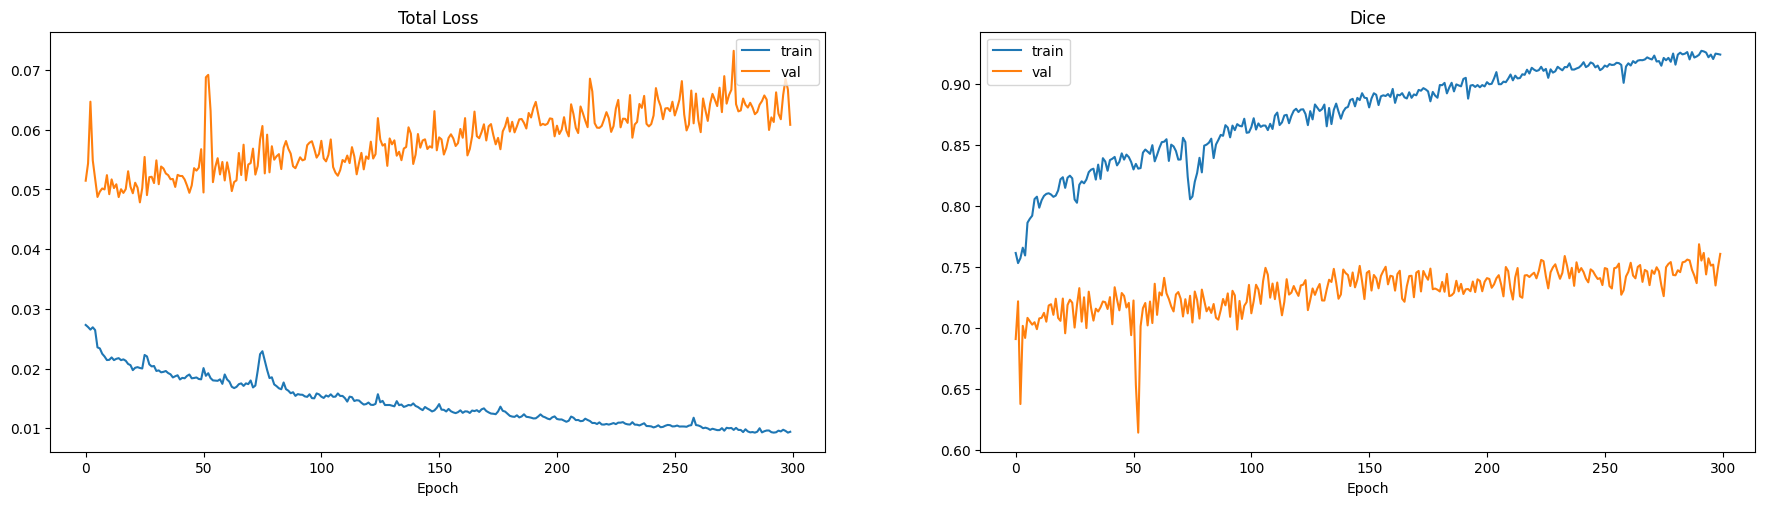

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(22, 12))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'],loc = 'upper right')


plt.subplot(2,2,2)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice')
plt.xlabel('Epoch')
plt.legend(['train','val'],loc = 'upper left')


In [ ]:
score = model.evaluate(
    X_test,Y_test_mask)
print('Test loss:',score[0])
print('Test segmentation dice:',score[1])

1/1 [==============================] - 0s 426ms/step - loss: 0.0796 - dice_coef: 0.7445
Test loss: 0.07960234582424164
Test segmentation dice: 0.7444584965705872


1/1 [==============================] - 0s 29ms/step


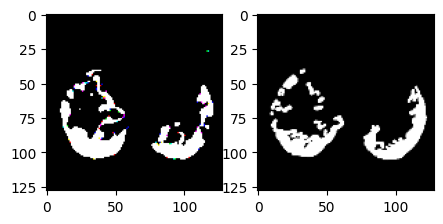

In [ ]:
pred = model.predict(X_test)

pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0
i = 5
plt.figure(figsize = (5, 8))
plt.subplot(1, 2, 1)
plt.imshow(pred[i])
plt.subplot(1, 2, 2)
plt.imshow(Y_test_mask[i])

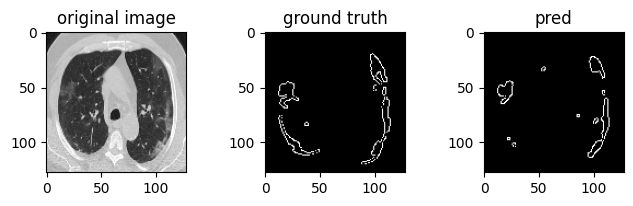

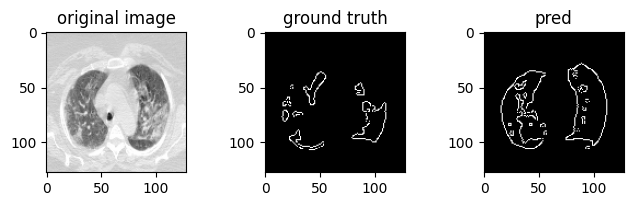

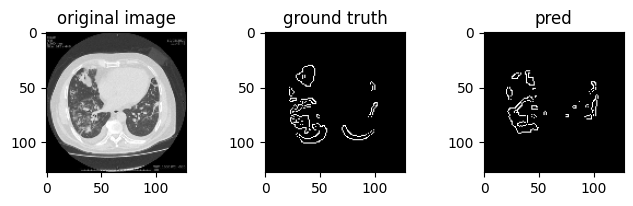

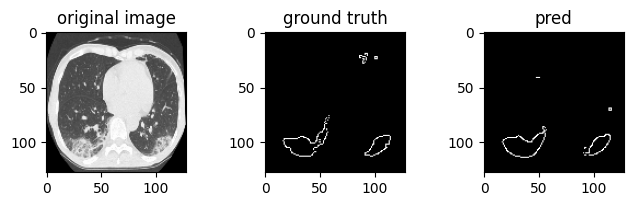

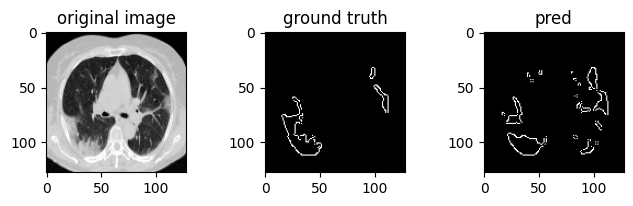

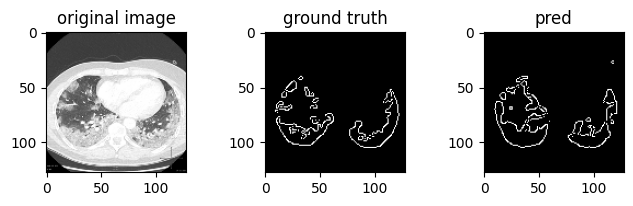

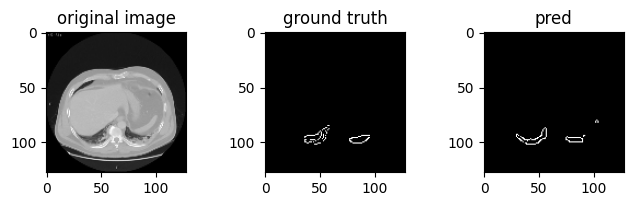

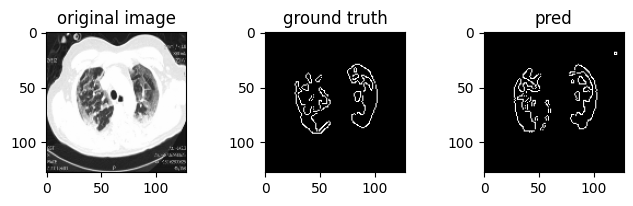

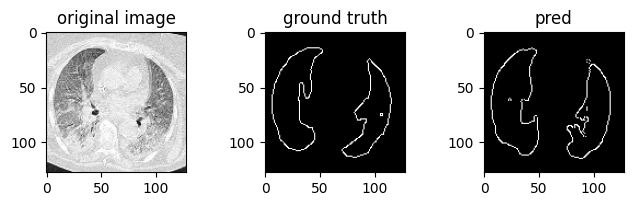

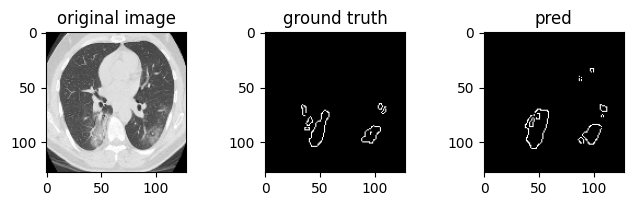

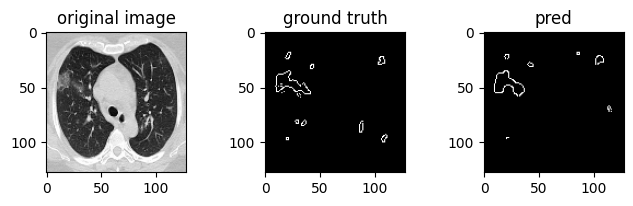

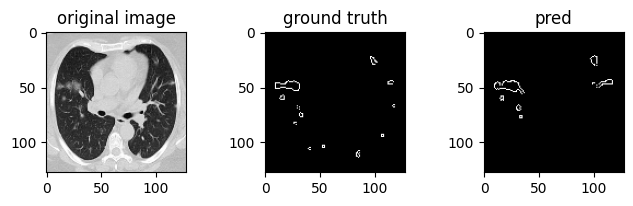

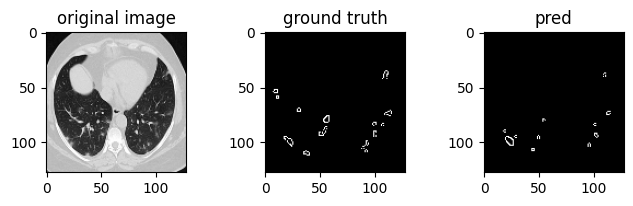

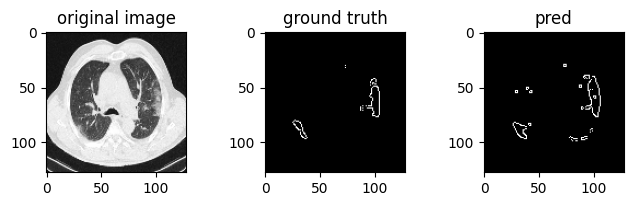

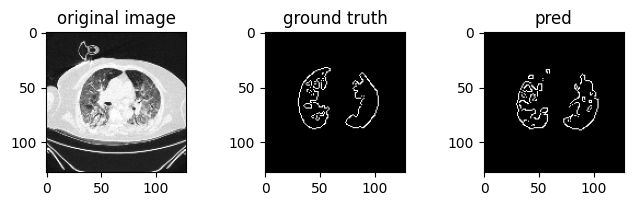

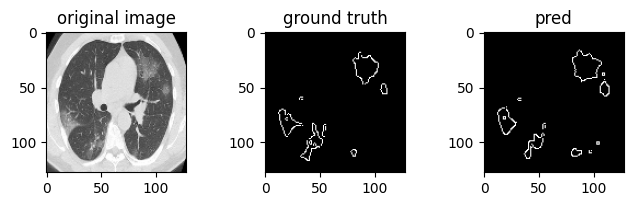

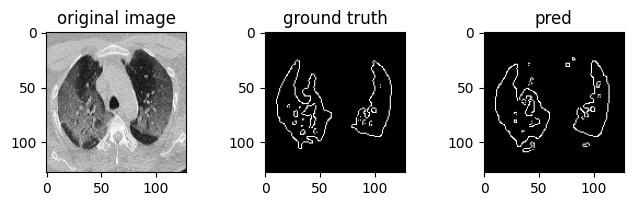

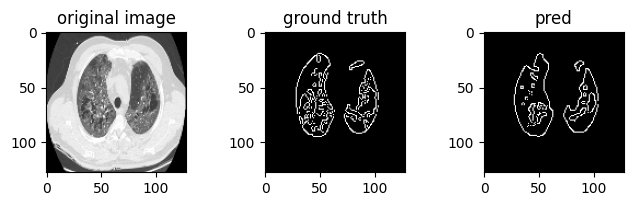

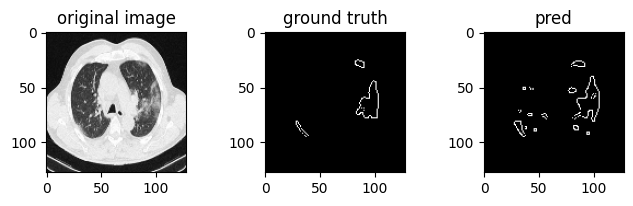

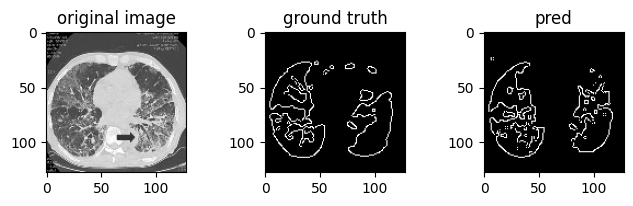

In [ ]:
Y_test_8bit = Y_test_mask.astype(np.uint8) # cv2.Canny只能輸入uint8
pred_8bit = pred.astype(np.uint8)
X_test_32 = X_test.astype(np.float32) # 64位浮點opencv只適用float32

for i in range(X_test.shape[0]):
  plt.figure(figsize = (8, 4))
  plt.subplot(2, 3, 1)
  plt.title("original image")
  plt.imshow(cv2.cvtColor(X_test_32[i],cv2.COLOR_BGR2RGB))
  plt.subplot(2, 3, 2)
  plt.title("ground truth")
  plt.imshow(cv2.Canny(Y_test_8bit[i], 0, 1),cmap = "gray")
  # plt.subplot(2, 3, 5)
  # plt.imshow(cv2.cvtColor(x_test_32[i] + convertToThreeChennel(cv2.Canny(y_test_8bit[i], 0, 1)), cv2.COLOR_BGR2RGB))
  plt.subplot(2, 3, 3)
  plt.title("pred")
  plt.imshow(cv2.Canny(pred_8bit[i], 0, 1),cmap = "gray")
  # plt.subplot(2, 3, 6)
  # plt.imshow(cv2.cvtColor(x_test_32[i] + convertToThreeChennel(cv2.Canny(y_test_8bit[i], 0, 1)), cv2.COLOR_BGR2RGB))
  plt.show()